# Regression Ruben Serdons

In [35]:
#Project 2, Ruben Serdons, Website Traffic dataset

## Imports


In [36]:
import pandas as pd
import seaborn as sns
pd.set_option('display.float_format', '{:.3f}'.format)

## Load data

In [37]:
df = pd.read_csv('../Data/website_data.csv')

In [38]:
print(df.shape)
df.head()

(2000, 7)


,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate
0,5,11.051,0.231,Organic,3.890,3,1.000
1,4,3.429,0.391,Social,8.478,0,1.000
2,4,1.621,0.398,Organic,9.636,2,1.000
3,5,3.629,0.180,Organic,2.072,3,1.000
4,5,4.236,0.292,Paid,1.961,5,1.000


## Data synthetisation with SDV

In Deep Learning P1 we used Time On Page as target variable.

<Axes: xlabel='Time on Page', ylabel='Count'>

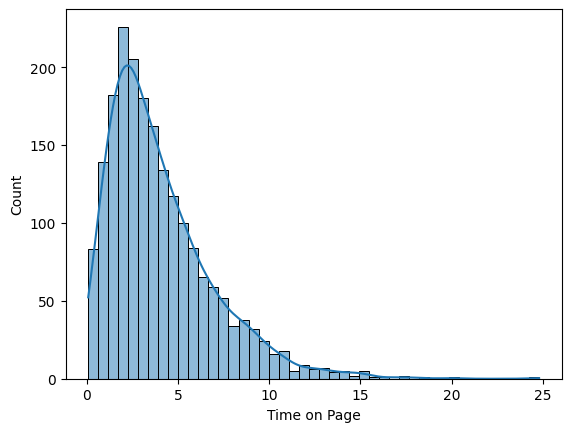

In [39]:
sns.histplot(data=df, x="Time on Page", kde=True)

### SDV -> GaussianCopulaSynthesizer

In [40]:
#%pip install sdv
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata

# sidenote: SDV + Copula can potentially use lots of RAM
# if there's a lot of original data

# current version of SDV requires a Metadata-object
# but it's enough you just wrap the DataFrame into it
metadata = Metadata.detect_from_dataframes(
    data={'website_traffic': df}
)

# initialize the Gaussian Copula Model
model = GaussianCopulaSynthesizer(metadata)

# fit the model
model.fit(df)

# use the model to generate 1000 new data rows
synthetic_data = model.sample(num_rows=2000)

synthetic_data

c:\Users\ruben\AppData\Local\Programs\Python\Python310\lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate
0,5,2.219,0.461,Paid,7.974,1,1.000
1,9,1.310,0.184,Organic,1.193,0,0.996
2,4,0.631,0.230,Organic,4.382,1,0.990
3,5,5.209,0.652,Organic,4.246,1,0.996
4,2,2.557,0.136,Social,2.710,0,1.000
...,...,...,...,...,...,...,...
1995,2,2.205,0.198,Organic,5.322,2,0.999
1996,5,0.467,0.385,Organic,1.293,1,0.991
1997,2,1.798,0.285,Organic,4.699,1,0.996
1998,4,1.467,0.132,Referral,2.740,3,0.997


In [41]:
# combine the synthetic data with the original one
df = pd.concat([df, synthetic_data])

<Axes: xlabel='Time on Page', ylabel='Count'>

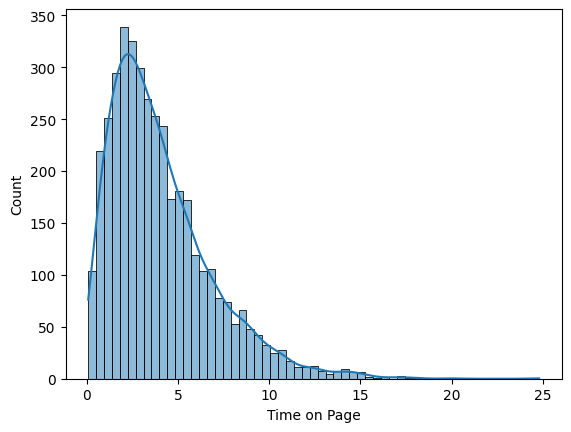

In [42]:
sns.histplot(data=df, x="Time on Page", kde=True)

## Undersampling 

In [43]:
# first we need to encode the "Traffic source" column
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Traffic Source'] = encoder.fit_transform(df['Traffic Source'])


In [44]:
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
pd.set_option('display.float_format', '{:.2f}'.format)

# removing some outliers first to make it easier to undesrample in the future
# can process the whole dataset 
# and compares variables to each other instead
# of focusing on outliers on a single variable
from sklearn.ensemble import IsolationForest

# adjust the contamination rate as you see fit
# for example, if you expect 5% of the data to be outliers
# you can use 0.05 etc. 
iso = IsolationForest(contamination=0.1) 

# fit isolation forest
y_pred = iso.fit_predict(df)

# filter outliers only
outliers = df[y_pred != 1]
df = df.drop(outliers.index)


In [45]:
outliers

,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate
16,6,18.34,0.34,3,2.98,0,1.00
20,11,0.79,0.25,1,11.69,5,1.00
22,3,11.65,0.29,0,6.03,1,1.00
28,3,0.82,0.16,3,15.02,3,1.00
35,2,4.71,0.68,4,3.87,4,1.00
...,...,...,...,...,...,...,...
1943,3,7.29,0.05,0,4.46,5,1.00
1951,0,0.50,0.22,3,10.10,1,1.00
1968,5,10.88,0.26,0,3.56,4,0.99
1969,10,0.72,0.10,4,3.07,0,1.00


<Axes: xlabel='Time on Page', ylabel='Count'>

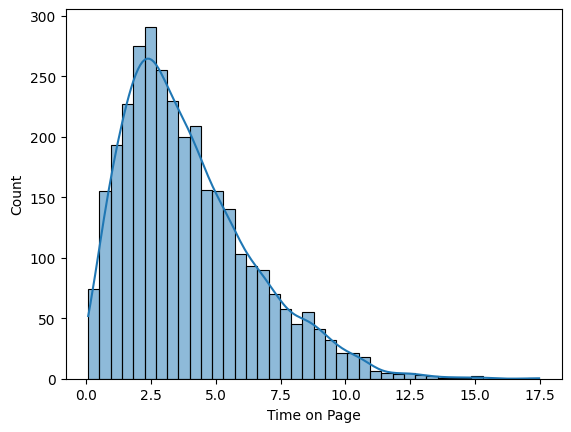

In [46]:
# histogram to see the distribution of target variable
sns.histplot(data=df, x="Time on Page", kde=True)

We could even remove more from the high end

In [47]:
import numpy as np

variable = "Time on Page"

Q1 = df[variable].quantile(0)
Q3 = df[variable].quantile(0.7)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df[(df[variable] < lower_bound) | (df[variable] > upper_bound)]
df = df.drop(outliers.index)

In [48]:
df.describe()

,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate
count,3200.00,3200.00,3200.00,3200.00,3200.00,3200.00,3200.00
mean,4.96,2.86,0.27,1.79,3.87,1.94,1.00
std,2.08,2.67,0.15,1.19,2.38,1.36,0.01
min,0.00,0.00,0.01,0.00,0.07,0.00,0.81
25%,3.00,0.86,0.16,1.00,2.05,1.00,1.00
50%,5.00,2.03,0.26,1.00,3.40,2.00,1.00
75%,6.00,4.10,0.37,3.00,5.28,3.00,1.00
max,13.00,17.84,0.84,4.00,11.87,9.00,1.00


Now let us check the new distribution

<Axes: xlabel='Time on Page', ylabel='Count'>

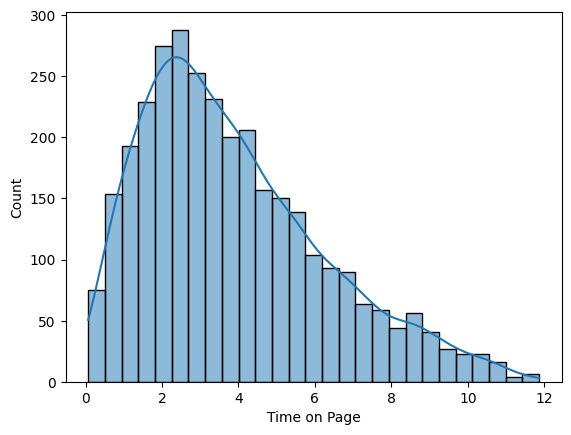

In [49]:
sns.histplot(data=df, x="Time on Page", kde=True)

Now the undersampling

In [50]:
# most of the data sampling and generation methods
# only work for classification targets
# we can still use these methods if we create a temporary binned
# version of our continuous variable. Just make sure you have enough 
# to capture the main idea of the whole target variable trend
target = "Time on Page"
df['target_binned'] = pd.cut(df[target], bins=8, labels=False)

<Axes: xlabel='target_binned', ylabel='Count'>

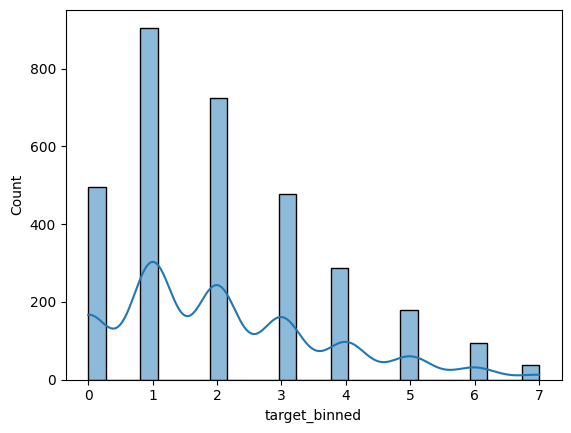

In [51]:
sns.histplot(data=df, x="target_binned", kde=True)

In [52]:
# let's have value counts, these are handy when 
# we use a sampling strategy
df['target_binned'].value_counts()

target_binned
1    906
2    724
0    496
3    478
4    288
5    178
6     93
7     37
Name: count, dtype: int64

In [53]:
# the variables minus "target" variable
# of course the real target variable is "Time on Page"
# but since we are optimizing data here, we are using the binned-version
# as the "target variable"
variables = df.drop('target_binned', axis=1).columns
X = df[variables]
y = df['target_binned']

# initialize the undersampling sampler
# with auto, we actually lost 95% of the data, so let's use a specified sampling strategy
strategy = {
    0: 200,  # Reduce from 508 to 200
    1: 400,  # Reduce from 917 to 400
    2: 300,  # Reduce from 730 to 300
    3: 250,  # Reduce from 477 to 250
    4: 150,  # Reduce from 285 to 150
    5: 100,  # Reduce from 167 to 100
    6: 90,   # Keep close to 93 (unchanged)
    7: 29    # Keep as-is
}# sampler = RandomUnderSampler(sampling_strategy=strategy, random_state=321)
sampler = ClusterCentroids(sampling_strategy=strategy)

# perform undersampling
X_resampled, y_resampled = sampler.fit_resample(X, y)

# reconstruct the dataframe
df_resampled = pd.DataFrame(X_resampled, columns=variables)
df_resampled['target_binned'] = y_resampled

In [54]:
df_resampled

,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate,target_binned
0,4,1.33,0.20,1,1.30,4,0.99,0
1,4,3.36,0.08,1,1.44,0,1.00,0
2,5,8.33,0.27,1,0.59,2,1.00,0
3,6,0.45,0.04,1,0.63,2,0.99,0
4,3,1.27,0.29,2,0.83,1,0.99,0
...,...,...,...,...,...,...,...,...
1514,4,0.18,0.20,1,10.71,0,1.00,7
1515,1,0.71,0.33,1,11.31,2,1.00,7
1516,5,1.76,0.29,1,10.98,2,1.00,7
1517,5,1.35,0.27,3,11.77,2,1.00,7


<Axes: xlabel='Time on Page', ylabel='Count'>

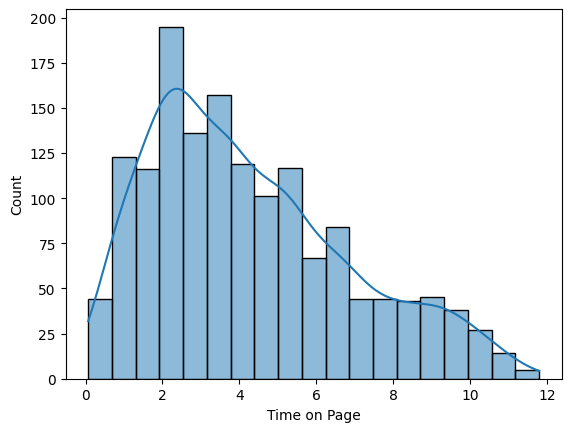

In [55]:
# the distribution is a bit closer to normal distribution
sns.histplot(data=df_resampled, x="Time on Page", kde=True)

## Noise management: RANSAC

In [56]:
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np

pd.set_option('display.float_format', '{:.1f}'.format)

In [57]:
# load data again, since we already took out outliers earlier
df = pd.read_csv('../Data/website_data.csv')

# encode the "Traffic Source" column
encoder = LabelEncoder()
df['Traffic Source'] = encoder.fit_transform(df['Traffic Source'])


In [58]:
# since RANSAC is a regression algorithm, X/y -split
X = df.drop("Time on Page", axis=1)
y = df["Time on Page"]

# initalize RANSAC regerssor and fit our data
# RANSAC needs a threshold in order to process data
# since our data is heavily skewed, we're gonna use this trick
ransac = RANSACRegressor(residual_threshold=np.std(y) * 1.5)
ransac.fit(X, y)

# now we have split the result into 
# inliers and outliers
# inliers => good data, follows the distribution nicely
# outliers => are far away from the main distribution
# the ~-sign (tilde) in pandas DataFrames means "the opposite of"
# so in this case => get everything from DataFrame EXCEPT the inliers
inlier_mask = ransac.inlier_mask_
outliers = df[~inlier_mask]
inliers = df[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")

Inliers: 1529
Outliers: 471


In [59]:
df.columns

Index(['Page Views', 'Session Duration', 'Bounce Rate', 'Traffic Source',
       'Time on Page', 'Previous Visits', 'Conversion Rate'],
      dtype='object')

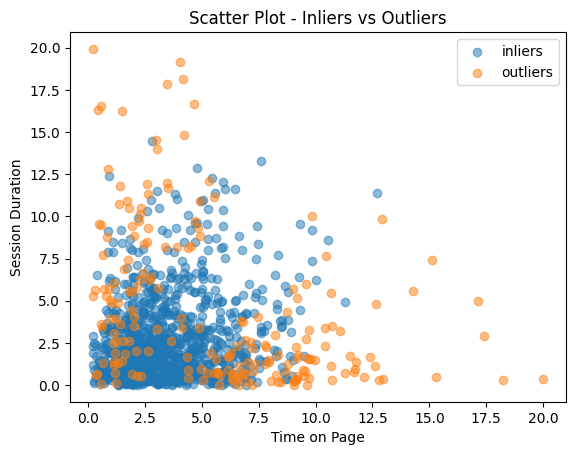

In [72]:
import matplotlib.pyplot as plt

variable = "Time on Page"
target = "Session Duration"

inliers_sample = inliers.sample(1000)
outliers_sample = outliers.sample(200)

plt.scatter(inliers_sample[variable], inliers_sample[target], label="inliers", alpha=0.5)
plt.scatter(outliers_sample[variable], outliers_sample[target], label="outliers", alpha=0.5)

plt.xlabel(variable)
plt.ylabel(target)

plt.title("Scatter Plot - Inliers vs Outliers")
plt.legend()
plt.show()

<Axes: xlabel='Time on Page', ylabel='Count'>

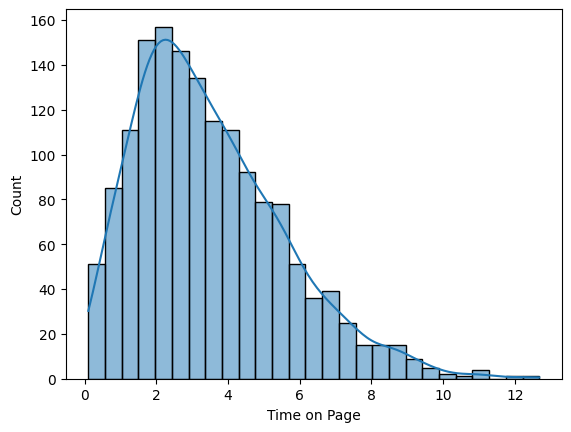

In [73]:
sns.histplot(data=inliers, x="Time on Page", kde=True)